<a href="https://colab.research.google.com/github/xmatx123/Mattis/blob/master/Earthquake_prediction_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Earthquake prediction challenge  -  Mattis Birkhahn

## **Step 1 - Import dependencies**

I like to thank Siraj Raval for inspiring me to participate at this challenge and learning to code machine learning algorithms

In [5]:
# install kaggle, math operations and machine learning algorithms
!pip install kaggle
!pip install numpy
!pip install catboost

    100% |████████████████████████████████| 60.6MB 641kB/s 


In [0]:
# import dependencies - preprocessing
import pandas as pd

# math operations
import numpy as np

# machine learning
from catboost import CatBoostRegressor, Pool

# data scaling
from sklearn.preprocessing import StandardScaler

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV

# support vector machine model
from sklearn.svm import NuSVR, SVR

# kernel ridge model
from sklearn.kernel_ridge import KernelRidge

# data visualization
import matplotlib.pyplot as plt



## **Step 2 - Import dataset from Kaggle**

In [9]:
# Colab file access
from google.colab import files

# retrieve uploaded file
uploaded = files.upload()

# move kaggle.json into the folder where API expects to find ...
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 /root/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [0]:
# access kaggle via list
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       2890           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11000           False  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4360           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         39           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       2898           False  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

In [10]:
# download kaggle earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 18.6MB/s]
 98% 236M/242M [00:01<00:00, 132MB/s]
100% 242M/242M [00:01<00:00, 141MB/s]
100% 2.02G/2.03G [00:37<00:00, 12.2MB/s]
100% 2.03G/2.03G [00:37<00:00, 58.2MB/s]


In [11]:
# unzip training data for usage
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


## **Step 3 - Exploratory Data Analysis**

In [12]:
# extract training data into dataframe for further manipulation on the data
train = pd.read_csv('train.csv', nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
# print out 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


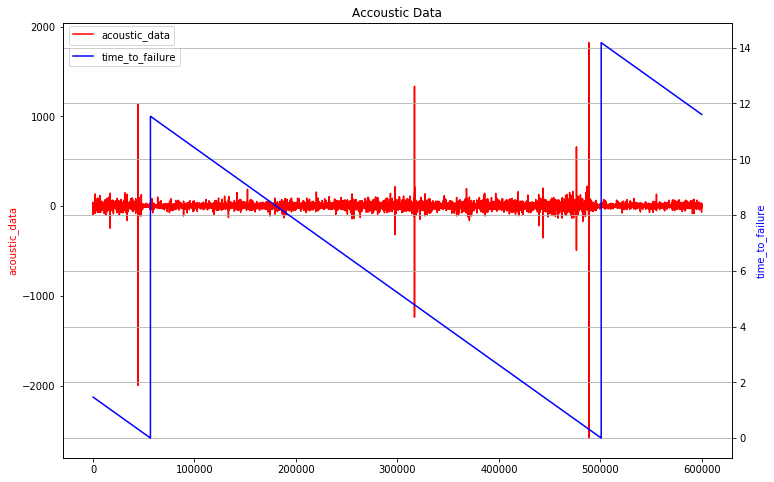

In [13]:
# visualize 1% of sample data for the first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

# function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Accoustic Data"):
  fig, ax1 = plt.subplots(figsize=(12, 8))
  plt.title(title)
  plt.plot(train_ad_sample_df, color='r')
  ax1.set_ylabel('acoustic_data', color='r')
  plt.legend(['acoustic_data'], loc=(0.01, 0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df, color='b')
  ax2.set_ylabel('time_to_failure', color='b')
  plt.legend(['time_to_failure'], loc=(0.01, 0.9))
  plt.grid(True)
  
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df
 

If you plot all of the data you see that right before every blue line there is a spike in the acoustic activity.... how to utilize it? other factors? etc.?


## **step 4 - Feature Engineering**

In [0]:
# create a function to generate some statistical features
def gen_features(X):
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X, 0.01))
  return pd.Series(strain)

In [21]:
# add features to the data

train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index = True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    
X_train.describe()

,0,1,2,3,4,5
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,68.297997,0.125830,-11.224603
std,0.256049,8.503939,265.087984,70.532565,0.477901,14.106852
min,3.596313,2.802720,-5515.000000,0.648602,-4.091826,-336.000000
25%,4.349497,4.478637,-154.000000,28.090227,-0.040779,-14.000000
50%,4.522147,5.618798,-111.000000,45.816625,0.085620,-10.000000
75%,4.693350,6.880904,-79.000000,78.664202,0.253930,-6.000000
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000


In [24]:
# implementing a machine learning model
# model 1 - Catboost
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=1000, loss_function = 'MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 2.114971506500883}}

## **step 6 - Implementing Support Vector Machine + Radial Basis Function Kernel**

support vector machine only takes values on a specific hyperplane into account (boundaries).
If the data is non-linear we use the kernel (dot-product). *Similarity-function allows then to analyze data linearly. Input space -> Feature space

In [35]:
# model 2 - SVM with RBF + Grid Search
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
              'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring=None)
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV Score: {:4f}".format(reg1.best_score_))
print(reg1.best_params_)


Best CV Score: 0.364565
{'C': 2, 'gamma': 0.1}


## **step 7 - Future ideas**


* Recurrent Networks
* Genetic Algorithms
* Ordinary Differential Equation Networks



